In [23]:
from sympy import *
import pandas as pd
from matplotlib import pyplot as plt
init_printing()

# Chapter 2. バースト検出

バースト検出： ウェブ上の活動の盛り上がり（**バースト**）を検出する。

例：
- 2011年3月の東日本大震災直後の「地震」のようなキーワードを含むツイート
- 「風の谷のナウシカ」放映時の「バルス」を含むツイート

### 単純に検出する方法

#### ある値を閾値として、それを超えたらアラートを出す

例：1秒間に10回以上、「バルス」を含むツイートが現れたらアラートを出す

普段の値が安定していて、スパイクしてすぐ戻るようであれば問題ない。

##### 課題

ある一点を境に、しばらく値が閾値を超え続けるような状況では、ずっとアラートが出続ける。
![](img/chapter2_1.png)

例えば、2011年3月10日までは秒10ツイート以上、「地震」というキーワードが含まれた時にアラートを上げる設定でよかったのが、翌日以降は定常状態が変化したためにそれでは過剰なアラートになるというような状況

履歴データから活動の一時的な盛り上がり「**バースト**」を検出する手法を考える。

応用先の例

- ソーシャルメディアの投稿
- サーバへのアクセス
- 購買数

例にあげたツイート数など、あらゆる活動の発生のことを**シグナル**の発生と総称する。

## 移動平均線収束拡散法

課題から、単なるシグナル量ではバースト検出するのは困難。

### 解決策

現在のシグナル発生量と過去の傾向を比較して、傾向を自動的に把握する。

### データの表し方

- 計測をスタートした時刻 <i>t<sub>0</sub></i>
    - 例： 2017/7/26 18:40:00
- 時間間隔 <i>Δt</i>
    - 例：1秒
    - 単位は秒でも分でも日でも週でも月でも年でもいい
- 計測の回数 <i>T</i>回
    - 例：3回
    - <i>t<sub>0</sub></i> = 2017/7/26 18:40:00、<i>Δt</i> = 1秒、 <i>T</i> = 3としたら
        2017/7/26 18:40:00〜2017/7/26 18:40:01
        2017/7/26 18:40:01〜2017/7/26 18:40:02
        2017/7/26 18:40:02〜2017/7/26 18:40:03
- 計測した時系列のデータ <i>F</i> = (<i>f</i><sub>1</sub>, <i>f</i><sub>2</sub>, ... <i>f</i><sub>T</sub>)
    - 例： <i>F</i> = (5, 3, 4...)
    - ![](img/chapter2_2.png)

<i>Δt</i>を1秒で置けば細かい時系列データ、1時間などにすると1日が24個のシグナル量で表現される。

#### 時系列データの例

|<i>i</i>|<i>f<sub>i</sub></i>|<i>Δf<sub>i</sub></i>|時刻|<i>i</i>|<i>f<sub>i</sub></i>|<i>Δf<sub>i</sub></i>|時刻|
|---|---|----|----|---|---|---|---|
|1|0|-|2013/4/23 23:10:16|11|297|20|2013/4/23 23:10:26|
|2|3|3|2013/4/23 23:10:17|12|1278|981|2013/4/23 23:10:27|
|3|11|8|2013/4/23 23:10:18|13|1477|199|2013/4/23 23:10:28|
|4|140|129|2013/4/23 23:10:19|14|4362|2885|2013/4/23 23:10:29|
|5|143|3|2013/4/23 23:10:20|15|4807|445|2013/4/23 23:10:30|
|6|132|-11|2013/4/23 23:10:21|16|4721|-86|2013/4/23 23:10:31|
|7|232|100|2013/4/23 23:10:22|17|4720|-1|2013/4/23 23:10:32|
|8|265|33|2013/4/23 23:10:23|18|4569|-151|2013/4/23 23:10:33|
|9|256|-9|2013/4/23 23:10:24|19|4295|-274|2013/4/23 23:10:34|
|10|277|21|2013/4/23 23:10:25|20|4305|10|2013/4/23 23:10:35|

![](img/chapter2_3.png)

このデータからシグナル量急増を検出する単純なアイデア

時刻 <i>i</i> - 1 と 時刻 <i>i</i> のシグナル量の差分 <i>Δf<sub>i</sub></i> に注目して、この値がある閾値を超えた時をバースト状態とみなす。

<i>Δf<sub>i</sub></i> = <i>f<sub>i</sub></i> - <i>f</i><sub><i>i</i>-1</sub>

一見よさそう。

たとえば、閾値500くらいにしておけば、i = 12 や i = 14は検出できそう。

##### 課題

- 時系列データ中の2点のみからデータ量の増減を把握しようとするため、観測値のばらつき（ノイズ）の影響を受けやすい。
    - 観測値のばらつきを軽減するには、より多くのデータ点を用いて、シグナル量の傾向を把握する必要性

##### 解決策

1. 時間解像度 <i>Δt</i>を長く（粗く）して、データを安定化させる
    - 検出間隔も間延びしてしまう
2. 時間解像度を変えずに、ある時刻の近くのシグナル量から平均値を算出して平滑化する
    - 時刻 i から過去に遡って n件のシグナル量の平均を計算する方法
        - **単純移動平均（SMA）**
        - $$
\begin{eqnarray}
\mathrm{SMA}_i^{(n)} &=& \frac{1}{n}\sum_{k=0}^{n-1}{f_{i-k}}
\\&=&\frac{1}{n}(f_i + f_{i-1} + f_{i-2}+ ...+ f_{i-k}) 
\end{eqnarray}
$$
        - 一般的な算術平均。とてもわかりやすい。
        - ただこれでは、最近でも過去でも同じように重み付けがなされてしまう。より最近の事案の影響を強め、古い事案についての重みは下げたい。
    - 重みを付けて平均を計算する方法
        - **指数移動平均（EMA）**
        - $$
\begin{eqnarray}
\mathrm{EMA}_i^{(n)} &=& \alpha f_{i} + (1-\alpha)\mathrm{EMA}_{i-1}^{(n)}
\\&=&\sum_{k=0}^{n-1}\alpha(1-\alpha)^{k}f_{i-k}
\\ただし、\alpha&=&\frac{2}{n+1}
\\\mathrm{EMA}_i^{(n)} &=&\sum_{k=0}^{n-1}\frac{2}{n+1}(1-\frac{2}{n+1})^{k}f_{i-k}
\\&=&\frac{2}{n+1}(1-\frac{2}{n+1})^{k}(f_i + f_{i-1} + f_{i-2}+ ...+ f_{i-k})
\end{eqnarray}
$$
        - たとえば、ロードアベレージも基本的な考え方はこれと同様
            - nの値が1分、5分、15分
        - 金融工学での利用とは違う

下のグラフは、
$$
\begin{eqnarray}
\sum_{k=0}^{n-1}\frac{2}{n+1}(1-\frac{2}{n+1})^{k}
\end{eqnarray}
$$
の部分の計算結果（*n* = 14の時）
これが、重みになる。

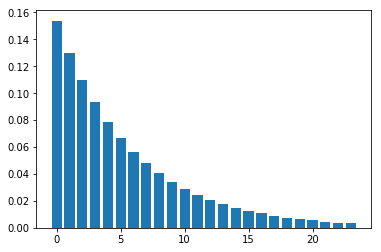

In [38]:
n=14
alpha = 2/(n-1)
series = pd.Series([alpha * (1-alpha)**i for i in range(n+10)])
plt.bar(left=range(n+10), height=series)
plt.show()

##### EMAの特長

- 最新のデータの重み係数が最も大きく、データが古くなると重み係数が指数関数的に減少していく
    - n が小さいことを「速い」、大きいことを「遅い」という

以前出た式、

$$
\begin{eqnarray}
\Delta f_i = f_i-f_{i-1}
\\の f_{i-1} を\mathrm{EMA}に置き換える。
\\f_i-\mathrm{EMA}_i^{(n)}
\end{eqnarray}
$$

以前よりも、データの時間的な影響度が考慮された指標になっているものの、今現在のデータ（*f<sub>i</sub>*）のばらつきは考慮できていないので、こっちもEMAで置き換える。置き換えたものは、**移動平均線収束拡散法（MACD）**の主要部になる。MACDは、株価や為替市場のトレンド分析などで使われる。
    
$$
\begin{eqnarray}
\mathrm{MACD}_i^{(n_1,n_2)} = \mathrm{EMA}_i^{(n_1)}-\mathrm{EMA}_i^{(n_2)}
\end{eqnarray}
$$
